Обращение к ревьюверу

# Описание:  
**Название проекта**

Проект: Второй сборный проект

**Описание исследования.**



**Цель исследования.**



**Действия, необходимые для достижения поставленной цели.**

Загрузить данные;  
Обработать;  
Проанализировать их;  
Выявить корреляции в данных;   
Подготовить данные для МО и обучить модель;  
Проверить метрики модели;
Выполнить предсказания используя модель;
Сделать вывод по проделанной работе;

**Исходные данные.**




**Данное исследование разделено по плану:**  
[1.Загрузка данных](#t001)  
[2. Предобработка данных](#t002)   
[3. Исследовательский анализ данныхъ](#t003)  
[4. Объединение таблиц](#t004)  
[5. Корреляционный анализ](#t005)  
[6. Использование пайплайнов](#t006)  
[7. Анализ важности признаков](#t007)  
[8. Сегментация покупателей](#t008)
[9. Общий вывод](#t009)

# 0. Подготовительные шаги и функции  


## Импортирую библиотеки

In [1]:
#%pip install phik
#%pip install shap
#%pip install scikit-learn-intelex
import os
import phik
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import kstest
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
#from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder


from sklearnex import patch_sklearn
patch_sklearn()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Объявляю константы  

In [2]:
#константа локального пути
LOCAL_DATA_PATH = 'c:/ps/project/HR/data/'
#константа пути в тренажере
TRAINER_DATA_PATH = '/datasets/'
#список имен датафреймов 
DF_NAMES = ['df_train_job_satisfaction_rate', 'df_test_features', 'df_test_target_job_satisfaction_rate', 'df_train_quit', 'df_test_target_quit']
# конатстна новой строки для использования в f' строках
NL = '\n'

RANDOM_STATE = 42

## Объявляю функции

In [3]:
def smape(a, f):
 return 100/len(a) * np.sum(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

<a id='t001'></a>
# 1. Загрузка данных 
## Для выполнения задачи заказчиком были переданы три набора данных  

Т.к. работу выполнял локально, в VScode добавил проверку где выполняется проект. Если не локально, то брать из расположения в тренажере.

## 1.1 Загрузка данных  

Решил немного упростить себе задачу и разложить данные из всех файлов по своим датафреймам сразу для первой и сторой задачи.

In [4]:
for f in DF_NAMES:
    if os.path.exists(LOCAL_DATA_PATH):
        globals()[f] = pd.read_csv(LOCAL_DATA_PATH + f.strip('df_') + '.csv', index_col='id')
    elif os.path.exists(TRAINER_DATA_PATH):
         globals()[f] = pd.read_csv(TRAINER_DATA_PATH + f.strip('df_') + '.csv', index_col='id')
    else:
        print('ALARMA! No files found!')

Посмотрю на то, что загрузилось.

## 1.2 Проверка содержимого в загруженных данных

Просмотрел загруженные данные. Сверил их с описанием. Несоответствия описанным данным не обнаружил.

<a id='t002'></a>  
# 2. Предобработка данных

## Посмотрю соответствие типов столбцов описанным в задаче типам.

Типы данных соответствуют хранимым ими данным. Пропуски наблюдаются в таблицах: **df_test_features, df_train_job_satisfaction_rate**. Их я буду обрабатывать позже, по условию задания, в паплайне.

## Проверю таблицы на дубликаты

##### Выведу список явных дубликатов

Явных нет. Поищу неявные.

Для каждой таблицы сформирую список столбцов с категоримальными данными, а остальные будут численными.

In [5]:
for f in DF_NAMES:
    print(f'Столбцы датафрейма {f}')
    globals()['col_cat_' + f.strip('df_')] = globals()[f].select_dtypes(include='object').columns.to_list()
    globals()['col_num_' + f.strip('df_')] = [x for x in globals()[f].columns.to_list() if x not in globals()['col_cat_' + f.strip('df_')]]
    print(f"Категориальные столбцы: \n {globals()['col_cat_' + f.strip('df_')]}\n"
          f"Численные столбцы: \n {globals()['col_num_' + f.strip('df_')]} \n")

Столбцы датафрейма df_train_job_satisfaction_rate
Категориальные столбцы: 
 ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
Численные столбцы: 
 ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'] 

Столбцы датафрейма df_test_features
Категориальные столбцы: 
 ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
Численные столбцы: 
 ['employment_years', 'supervisor_evaluation', 'salary'] 

Столбцы датафрейма df_test_target_job_satisfaction_rate
Категориальные столбцы: 
 []
Численные столбцы: 
 ['job_satisfaction_rate'] 

Столбцы датафрейма df_train_quit
Категориальные столбцы: 
 ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
Численные столбцы: 
 ['employment_years', 'supervisor_evaluation', 'salary'] 

Столбцы датафрейма df_test_target_quit
Категориальные столбцы: 
 ['quit']
Численные столбцы: 
 [] 



Взгляну на уникальные значения в категориальных столбцах. Не исключено, что в них могут быть очепятки и\или иные артефакты.

В **df_test_features** столбцы _dept, level и workload_, и в таблице **df_test_target_quit** столбец _dept_ содержат пропуски. Об этом было указано чуть раньше, а обработаю это в конвеере.

**Вывод:** данные в датафреймах не содержат явных или неявных дублей. Присутствуют пропуски.

<a id='t003'></a>  
# 3. Исследовательский анализ данных

## Выведу описательную статистику по каждой таблице

По описательной статистике можно сказать, что аномалий в данных не наблюдаются. Значение дисперсии и среднего ожидаемые.

## Построю графики

#### Категориальные признаки

По гистограммам можно сделать следующие наблюдения. Вцелом распределение данных поддается логике и ожидаемо. В наборе данных наблюдается сравнительно мизерное количество сотрудников с повышением ЗП. в таблице целевых признакам наблюдается дисбаланс признаков.

####  Построю для численных данных пару графиков гистограмму и ящик с усами, а заодно тест Колмогорова-Смирнова, чтобы получить нормальность распределения.

Выводом станет распределение имен колонок по спискам в константах, которые будут в дальнейшем использованы в паплайнах.

In [6]:
OHE_COLUMNS = ['dept']
ORD_COLUMNS = ['level', 'workload']
NUM_COLUMNS = ['employment_years', 'supervisor_evaluation', 'salary']
BIN_COLUMNS = ['last_year_promo', 'last_year_violations']

<a id='t004'></a>  
#  4. Подготовка данных

### Исправлю порядок в тестовых данных

In [7]:
df_test_features = df_test_features.merge(df_test_target_job_satisfaction_rate, how = 'left', on='id')
display(df_test_features)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75
...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,0.56
109582,technology,middle,low,3,no,no,2,21600,0.14
305653,technology,junior,low,1,no,no,3,14400,0.11


### Объявлю конвеер для OneHotEncoder

In [ ]:
r_o_s = RandomOverSampler(random_state = RANDOM_STATE)

In [8]:
bin_pipe = Pipeline([
    ('simpleImputer_bin', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
])

In [9]:
ohe_pipe = Pipeline([
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]) 

Объявлю конвеер для OrdinalEncoder

In [10]:
ord_pipe = Pipeline([
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],], 
                            handle_unknown='use_encoded_value', 
                            unknown_value=np.nan
            )),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

Собираю все вместе и добавляю обработку численных признаков MinMaxScaler'ом

In [11]:
data_preprocessor = ColumnTransformer(
    [
        ('num', MinMaxScaler(), NUM_COLUMNS),
        ('bin', bin_pipe, BIN_COLUMNS),
        ('ohe', ohe_pipe, OHE_COLUMNS),
        ('ord', ord_pipe, ORD_COLUMNS)
    ], 
    remainder='passthrough'
) 

<a id='t005'></a>  
#  5. Обучение моделей

Объявлю метрику из заранее созданной функции

In [12]:
smape_score = make_scorer(smape, greater_is_better=False)

Объявлю словарь гиперпараметров моделей

In [13]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,300), 
        'models__min_samples_leaf': [2, 3 , 4, 5, 6, 7],
        'models__min_samples_split': [2, 4, 6],
        'models__max_leaf_nodes': range(2,300),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Итоговый паплайн

In [14]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

Определю автоматический поиск моделей через RandomizedSearchCV

In [15]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid, 
    scoring=smape_score, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

Выделю из тренировочной выбоки целевые признаки

In [16]:
X_train = df_train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis = 1)
y_train = df_train_job_satisfaction_rate['job_satisfaction_rate']
X_test = df_test_features.drop(['job_satisfaction_rate'], axis = 1)
y_test = df_test_features['job_satisfaction_rate']

In [17]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               MinMaxScaler(),
                                                                               ['employment_years',
                                                                                'supervisor_evaluation',
                                                                                'salary']),
                                                                              ('bin',
                                                                               Pipeline(steps=[('simpleImputer_bin',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(drop='if_binary',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['...
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [18]:
#print("\n Лучшая модель:\n", randomized_search.best_estimator_)
print(f'\n Лучший результат метрики по всем гиперпараметрам: {(-randomized_search.best_score_):.2f}')
print(f'\n Лучшие переметры среди всех гиперпараметров:\n {randomized_search.best_params_}')
#pred = randomized_search.predict(X_test)
print(f'\n Метрика SMAPE на тестовой выборке: {smape(y_test, randomized_search.predict(X_test)):.2f}')


 Лучший результат метрики по всем гиперпараметрам: 14.18

 Лучшие переметры среди всех гиперпараметров:
 {'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 4, 'models__min_samples_leaf': 2, 'models__max_leaf_nodes': 263, 'models__max_depth': 134, 'models': DecisionTreeRegressor(random_state=42)}

 Метрика SMAPE на тестовой выборке: 13.43


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


<a id='t006'></a>  
#  6. Вывод Задачи-1

Лучшей моделью оказалось дерево решений. Причиной тому стало отсутствие нормализации в тренировочных признаках и наличие выбросов. С этими задачами линейные модели справляются значительно хуже.

# Задача-2

Некоторые шаги описанные в задании я уже выполнил ранее. Я их пропущу и перейду сразу к анализу данных.

<a id='t007'></a>  
#  Анализ данных

Составлю портрет уволившегося сотрудника. df_train_quit

### Для простоты понимания характера увольняющегося сотрудника визуализирую его круговыми диаграммами.

### Описательный портрет увольняющегося сотрудника.

Из полученных выше графиков можно сделать вывод, что чаше всего покидают компанию младшие сотрудники из отдела продаж имеющие среднюю оценку руководителя с не высокой загрузкой проработавшие 1-2 года без повышения ЗП имеющий нарушения трудового договора.

### Проверю предположение аналитиков о том, что уровлетворенность работой влияет на увольнение сотрудника

Объединю данные из двух таблий, для удобства дальнейшей работы.

Построю диаграмму для признака

<a id='t008'></a>  
# Добавление нового входного признака

In [19]:
df_train_quit['satis'] = randomized_search.predict(df_train_quit)
df_test_features['satis'] = randomized_search.predict(df_test_features)
display(df_train_quit, df_test_features)

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,satis
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.657619
814010,sales,junior,medium,2,no,no,4,27600,no,0.824000
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.369167
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.356875
910140,marketing,junior,medium,2,no,no,5,25200,no,0.824000
...,...,...,...,...,...,...,...,...,...,...
588809,sales,junior,medium,4,no,no,3,26400,no,0.508286
672059,sales,middle,high,9,no,no,4,52800,no,0.832647
536432,purchasing,junior,low,2,no,yes,4,12000,yes,0.548750


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,satis
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,0.824000
686555,hr,junior,medium,1,no,no,4,30000,0.72,0.667941
467458,sales,middle,low,5,no,no,4,19200,0.64,0.652222
418655,sales,middle,low,6,no,no,4,19200,0.60,0.652222
789145,hr,middle,medium,5,no,no,5,40800,0.75,0.824444
...,...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,0.56,0.503333
109582,technology,middle,low,3,no,no,2,21600,0.14,0.190000
305653,technology,junior,low,1,no,no,3,14400,0.11,0.185962


<a id='t009'></a>  
# Подготовка данных

In [70]:
df = df_test_features.merge(df_test_target_quit, how='left', on='id')
X_test = df.drop(['quit', 'dept'], axis=1)
y_test = df['quit']

In [71]:
r_o_s = RandomOverSampler(random_state = RANDOM_STATE)
X_train = df_train_quit.drop(['quit', 'dept'], axis=1)
y_train = df_train_quit['quit']
#resampler = Pipeline(['ros', r_o_s])
#X_train, y_train = resampler.fit_resample(X_train, y_train)

In [72]:
display(X_test)

,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,satis
id,,,,,,,,,
485046,junior,medium,2,no,no,5,28800,0.79,0.824000
686555,junior,medium,1,no,no,4,30000,0.72,0.667941
467458,middle,low,5,no,no,4,19200,0.64,0.652222
418655,middle,low,6,no,no,4,19200,0.60,0.652222
789145,middle,medium,5,no,no,5,40800,0.75,0.824444
...,...,...,...,...,...,...,...,...,...
393147,junior,low,3,no,no,3,20400,0.56,0.503333
109582,middle,low,3,no,no,2,21600,0.14,0.190000
305653,junior,low,1,no,no,3,14400,0.11,0.185962


In [73]:
NUM_COLUMNS = ['employment_years', 'supervisor_evaluation', 'salary', 'satis']


Закодирую целевые признаки

In [74]:
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
display(y_test_encoded)

array([0, 0, 0, ..., 1, 0, 0])

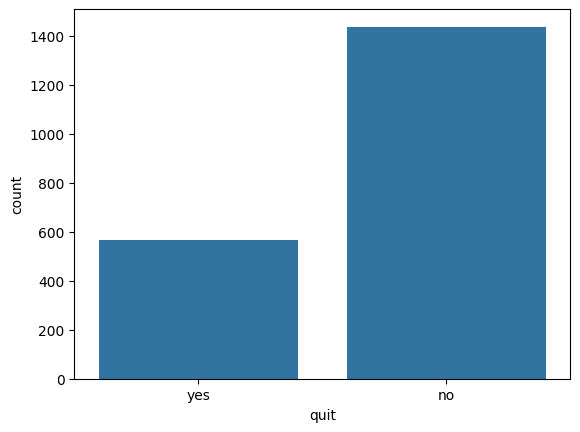

In [75]:
ax = sns.countplot(x='quit', data = df_test_target_quit)
plt.show()

### Конвейеры предобработки

In [76]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

In [77]:
bin_pipe = Pipeline([
    ('simpleImputer_bin', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
])

In [78]:
ohe_pipe = Pipeline([
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]) 

In [79]:
ord_pipe = Pipeline([
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],], 
                            handle_unknown='use_encoded_value', 
                            unknown_value=np.nan
            )),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [80]:
data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, NUM_COLUMNS),
        ('bin', bin_pipe, BIN_COLUMNS),
       # ('ohe', ohe_pipe, OHE_COLUMNS),
        ('ord', ord_pipe, ORD_COLUMNS)
    ], 
    remainder='passthrough'
) 

### Параметры моделей

In [131]:
param_grid = [
    
    # Параметры для LogisticRegression / liblinear / l2 / 0.92% -> 0.90%
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l2')],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # Параметры для LogisticRegression / saga / l2 / 0.92% -> 0.90%
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='saga', penalty='l2', max_iter=10000)],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # Параметры для LogisticRegression / lbfgs / 0.92% -> 0.90%
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', max_iter=10000)],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),]
    },
    
    
    # Параметры для DecisionTreeClassifier / 0.92% -> 0.91%
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=4, max_features=4)],
        'model__max_depth': range(3, 7),
        'model__max_features': range(3, 7),
        'model__min_samples_leaf': range(2, 3),
        'model__min_samples_split': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # Параметры для KNeighborsClassifier / 0.92% -> 0.91%
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(4, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # Параметры для SVC с ядром 'rbf' / 0.93% -> 0.93%
    {
        'model': [
            SVC(
                probability=True,
                random_state=RANDOM_STATE,
                kernel='rbf',
                gamma=0.28)
        ],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),]
    },
    
    # Отдельные параметры для SVC с ядром 'poly' / 0.93% -> 0.91%
    {
        'model': [
            SVC(
                probability=True,
                random_state=RANDOM_STATE,
                kernel='poly',
                gamma=0.28)
        ],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__degree': [4, 6, 8],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),]
    }
]

In [132]:
pipe_final = Pipeline(
    [
        ('ros', RandomOverSampler()),
        ('preprocessor', data_preprocessor),
        ('model', LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', penalty='l2'))
    ]
)

In [133]:
rs = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

### Обучение модели и получение метрик

In [134]:
rs.fit(X_train, y_train_encoded)

RandomizedSearchCV(estimator=Pipeline(steps=[('ros', RandomOverSampler()),
                                             ('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['employment_years',
                                                                                'supervisor_evaluation',
                                                                                'salary',
                                                                                'satis']),
                                                                              ('bin',
                                                                               Pipeline(steps=[('simpleImputer_bin',
                                                                                                Si...
                                        {'model': [SVC(gamma=0.28,
                                                       probability=True,
                                                       random_state=42)],
                                         'model__C': [0.01, 0.1, 1, 10, 100],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'model': [SVC(gamma=0.28,
                                                       kernel='poly',
                                                       probability=True,
                                                       random_state=42)],
                                         'model__C': [0.01, 0.1, 1, 10, 100],
                                         'model__degree': [4, 6, 8],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

Подготовлю тестовые данные добавив столбец у

In [135]:
pred = rs.predict(X_test)

display(X_test['dept'].value_counts())
display(X_train['dept'].value_counts())

In [136]:
display(pred)

array([0, 0, 0, ..., 1, 0, 0])

In [137]:
#print("\n Лучшая модель:\n", rs.best_estimator_)
print(f'\n Лучший результат метрики по всем гиперпараметрам: {(rs.best_score_):.2f}')
print(f'\n Лучшие переметры среди всех гиперпараметров:\n {rs.best_params_}')
print(f'\n Метрика на тестовой выборке: {roc_auc_score(y_test_encoded, pred):.2f}')


 Лучший результат метрики по всем гиперпараметрам: 0.93

 Лучшие переметры среди всех гиперпараметров:
 {'preprocessor__num': MinMaxScaler(), 'model__C': 10, 'model': SVC(gamma=0.28, probability=True, random_state=42)}

 Метрика на тестовой выборке: 0.89


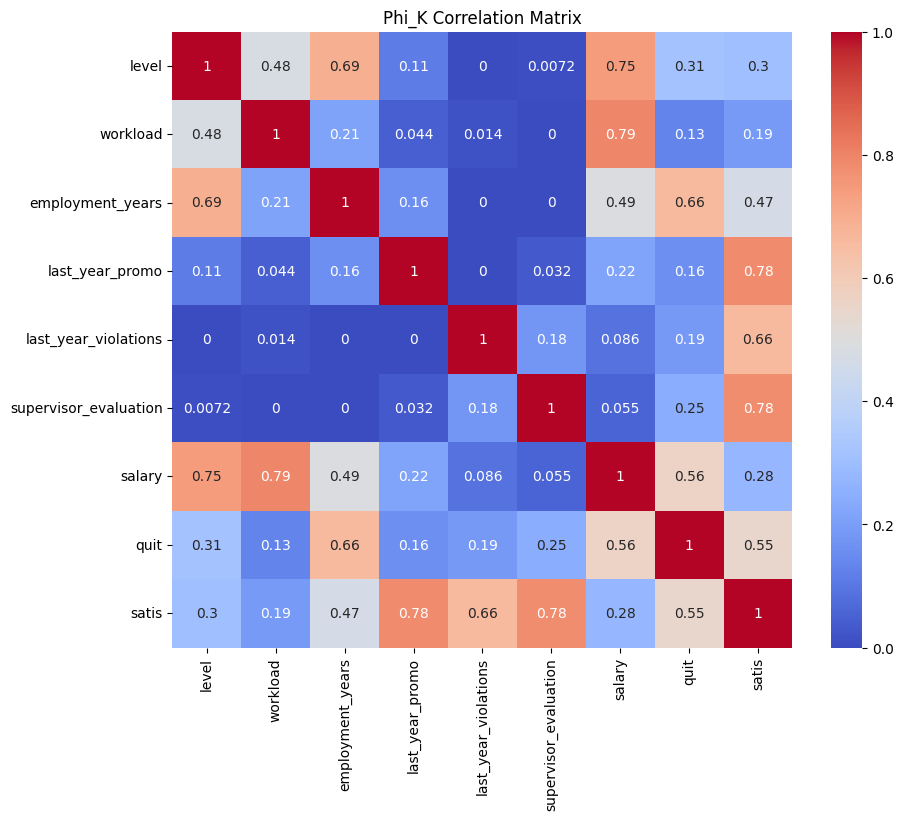

In [88]:
df_temp = df_train_quit.drop('dept', axis=1)
corr_matrix = df_temp.phik_matrix(interval_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'satis'])
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()